In [119]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import ssl
import re
from urllib.request import urlopen
import json

# ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# defined function which collects information from BBC website, and carefully considers error handling using exception
def collect_page_data(url):
    try:
        document = urlopen(url, context=ctx)
        html = document.read()
        soup = BeautifulSoup(html, "html.parser")
    except Exception as e: 
        print(f"failed to fetch page: {e}")
        return None


    # extract title
    title_tag = soup.find(id = "main-heading")
    title = title_tag.text if title_tag else "N/A"
    
    
    # extract total time
    time_tag = soup.find_all("dd") 
    total_time = 0 if time_tag else "N/A"
    for tag in time_tag:
        if "mins" in tag.text:
            num_in_tag = re.search(r'\d+', tag.text)
            total_time += int(num_in_tag.group())
            

    # extract image URL
    image_tag = soup.find("img")
    image = image_tag["src"] if image_tag else "N/A"

    # extract ingredients
    ingredients_list = soup.find("div", {"data-testid": "recipe-ingredients"})
    ingredients = ingredients_list.find("ul").text.strip() if ingredients_list else "N/A"

    
    # extract rating value 
    rating_tag = soup.find("div", {"data-testid": "recipe-rating"})
    rating_val = rating_tag.find_all("span")[6].text.strip() if rating_tag and rating_tag.find_all("span") else "N/A"
    
    
    # extract rating count 
    rating_count_tag = soup.find("div", {"data-testid": "recipe-rating"})
    rating_count = rating_tag.find_all("span")[8].text.strip() if rating_tag and rating_tag.find_all("span") else "N/A"

        
    # locate JSON-LD script and parse for recipe category
    script_tag = soup.find("script", {"type": "application/ld+json"})
    json_category = "N/A"

    if script_tag:
        data = json.loads(script_tag.string)
        category = data["@graph"][0].get("recipeCategory", "N/A")  

    
    # location JSON-LD script and parse for recipe cuisine
    script_tag = soup.find("script", {"type": "application/ld+json"})
    json_cuisine = "N/A"

    if script_tag:
        data = json.loads(script_tag.string)
        cuisine = data["@graph"][0].get("recipeCuisine", "N/A")  
        
   
    # extract diet from JSON-LD
    script_tag = soup.find("script", {"type": "application/ld+json"})
    json_diet = []
    if script_tag:
        data = json.loads(script_tag.string)
        json_diet = [diet.split("/")[-1] for diet in data["@graph"][0].get("suitableForDiet", [])]

    # extract diet from HTML and combine data for output
    html_diet = [a.text.strip() for tag in soup.find_all("dd") for a in tag.find_all("a")]
    diet = ", ".join(json_diet + html_diet) or "N/A"

    
    # determine vegan and vegetarian status
    vegan = "Yes" if "vegan" in diet.lower() else "No"
    vegetarian = "Yes" if "vegetarian" in diet.lower() else "No"

   
    data = {
        "Title": [title],
        "Total Time": str(total_time) + " " + "minutes",
        "Image URL": [image],
        "Ingredients": [ingredients],
        "Rating Value": str(rating_val)  + " " + "stars",
        "Rating Count": [rating_count],
        "Category": [category],
        "Cuisine": [cuisine],
        "Diet": [diet],
        "Vegan": [vegan],
        "Vegetarian": [vegetarian],
        "URL": [url]
    }
    df = pd.DataFrame(data)

    # save work as a CSV file
    df.to_csv("bbc_recipe.csv", index=False)
    print("\nData saved to bbc_recipe.csv\n")

    pd.set_option('display.max_colwidth', None)  
    pd.set_option('display.colheader_justify', 'center') 
    print(df.to_markdown(index=False)) 

    return df

# test URL and output
test_url = "https://www.bbc.co.uk/food/recipes/avocado_pasta_with_peas_31700"
df = collect_page_data(test_url)

df = pd.read_csv('bbc_recipe.csv')
df


Data saved to bbc_recipe.csv

| Title                            | Total Time   | Image URL                                                                                      | Ingredients                                                                                                                                                                                                                                       | Rating Value   | Rating Count   | Category    | Cuisine   | Diet                                                                                                                                      | Vegan   | Vegetarian   | URL                                                              |
|:---------------------------------|:-------------|:-----------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------

,Title,Total Time,Image URL,Ingredients,Rating Value,Rating Count,Category,Cuisine,Diet,Vegan,Vegetarian,URL
0,Avocado pasta with peas and mint,40 minutes,https://ichef.bbci.co.uk/food/ic/food_16x9_1600/recipes/avocado_pasta_with_peas_31700_16x9.jpg,"375g/13oz pasta, such as penne or fusilli1 large avocado (or 2 small) 2 garlic cloves2 tbsp coconut oil, melted½ tsp salt 1 lemon, juice and zest 6 fresh mint leaves150g/5½oz fresh peas (or frozen and defrosted) 1 large red chilli (optional)",4.0 stars,37 ratings,Main course,NaN,"LowLactoseDiet, LowCalorieDiet, VeganDiet, VegetarianDiet, Dairy-free, Egg-free, Healthy, Nut-free, Pregnancy-friendly, Vegan, Vegetarian",Yes,Yes,https://www.bbc.co.uk/food/recipes/avocado_pasta_with_peas_31700


In [153]:
import pandas as pd 

recipe_data = pd.read_csv("recipes.csv")



In [154]:
recipe_data

,Unnamed: 0,id,title,image_url,recipe_url,rating_avg,rating_val,total_time,category,cuisine,ingredients
0,0,1,A classic sponge cake,https://food-images.files.bbci.co.uk/food/recipes/aclassicspongecakewi_9406_16x9.jpg,https://www.bbc.co.uk/food/recipes/aclassicspongecakewi_9406,4.285714,7,90,Cakes and baking,,"passion fruit, fromage frais, egg, mascarpone, caster sugar, baking powder, self-raising flour, vanilla extract, butter"
1,1,2,Adaptable bean soup,https://food-images.files.bbci.co.uk/food/recipes/nigelsadaptablebeans_92230_16x9.jpg,https://www.bbc.co.uk/food/recipes/nigelsadaptablebeans_92230,5.000000,11,60,Light meals & snacks,,"orange, swiss chard, onion, carrot, tomato, olive oil, parmesan, parsley, black pepper, bay leaf, vegetable stock, cannellini beans, French bread"
2,2,3,Affogato,https://food-images.files.bbci.co.uk/food/recipes/affogato_72443_16x9.jpg,https://www.bbc.co.uk/food/recipes/affogato_72443,4.000000,6,30,Desserts,Italian,"ice cream, coffee granules"
3,3,4,Albanian baked lamb with rice (Tavë kosi),https://food-images.files.bbci.co.uk/food/recipes/albanian_baked_lamb_with_92485_16x9.jpg,https://www.bbc.co.uk/food/recipes/albanian_baked_lamb_with_92485,4.611111,18,150,Main course,East European,"lamb shoulder, garlic, olive oil, egg, yoghurt, black pepper, nutmeg, oregano, long-grain rice, butter, plain flour"
4,4,5,All-day breakfast frittata,https://food-images.files.bbci.co.uk/food/recipes/all-day_breakfast_12416_16x9.jpg,https://www.bbc.co.uk/food/recipes/all-day_breakfast_12416,5.000000,10,60,Main course,,"bacon, potato, cherry tomatoes, mushroom, spinach, vegetable oil, egg, black pepper"
...,...,...,...,...,...,...,...,...,...,...,...
3288,3288,3289,"Pumpkin, chilli and coconut soup",https://food-images.files.bbci.co.uk/food/recipes/pumpkin_soup_45815_16x9.jpg,https://www.bbc.co.uk/food/recipes/pumpkin_soup_45815,4.500000,6,60,Light meals & snacks,British,"garlic, onion, chilli pepper, butternut squash, sweet potato, black pepper, ginger, thyme, coconut milk"
3289,3289,3290,Punjabi chicken curry,https://food-images.files.bbci.co.uk/food/recipes/punjabi_chicken_curry_44800_16x9.jpg,https://www.bbc.co.uk/food/recipes/punjabi_chicken_curry_44800,4.585366,41,90,Main course,Indian,"whole chicken, garlic, onion, tomato, vegetable oil, salt, ginger, cumin, cinnamon, coriander, turmeric, chilli powder, cardamom, garam masala, chicken stock, white rice"
3290,3290,3291,Puy lentil lasagne,https://food-images.files.bbci.co.uk/food/recipes/puy_lentil_lasagne_23244_16x9.jpg,https://www.bbc.co.uk/food/recipes/puy_lentil_lasagne_23244,4.850000,20,90,Main course,,"garlic, onion, leek, mushroom, mixed salad, chopped tomatoes, olive oil, milk, double cream, parmesan, cheddar, black pepper, vegetable stock, Puy lentils, lasagne sheets, butter, plain flour"
3291,3291,3292,Pytt i panna,https://ichef.bbci.co.uk/images/ic/640xn/p033hrpn.jpg,https://www.bbc.co.uk/food/recipes/pytt_i_panna_28950,5.000000,2,60,Main course,Nordic,"pork sausage, lardons, lingonberry, onion, carrot, potato, mushroom, beetroot, vegetable oil, egg, marjoram, thyme, butter"


In [155]:
recipe_data.isnull().sum()

Unnamed: 0     0
id             0
title          0
image_url      0
recipe_url     0
rating_avg     0
rating_val     0
total_time     0
category       0
cuisine        0
ingredients    0
dtype: int64

In [156]:
recipe_data.value_counts()

Unnamed: 0  id    title                                        image_url                                                                                  recipe_url                                                         rating_avg  rating_val  total_time  category          cuisine                    ingredients                                                                                                                                                                                         
0           1     A classic sponge cake                        https://food-images.files.bbci.co.uk/food/recipes/aclassicspongecakewi_9406_16x9.jpg       https://www.bbc.co.uk/food/recipes/aclassicspongecakewi_9406       4.285714    7           90          Cakes and baking                             passion fruit, fromage frais, egg, mascarpone, caster sugar, baking powder, self-raising flour, vanilla extract, butter                                                                                

In [157]:
recipe_data_drop = recipe_data.drop_duplicates()

In [158]:
# function to treat the missing or incorrect values
def clean_data(recipe_data):
    recipe_data=recipe_data.fillna('Missing')
    return recipe_data

pd.isnull(recipe_data).sum() 

cleaned = clean_data(recipe_data)

pd.isnull(recipe_data).sum() 

recipe_data.describe()

recipe_data


,Unnamed: 0,id,title,image_url,recipe_url,rating_avg,rating_val,total_time,category,cuisine,ingredients
0,0,1,A classic sponge cake,https://food-images.files.bbci.co.uk/food/recipes/aclassicspongecakewi_9406_16x9.jpg,https://www.bbc.co.uk/food/recipes/aclassicspongecakewi_9406,4.285714,7,90,Cakes and baking,,"passion fruit, fromage frais, egg, mascarpone, caster sugar, baking powder, self-raising flour, vanilla extract, butter"
1,1,2,Adaptable bean soup,https://food-images.files.bbci.co.uk/food/recipes/nigelsadaptablebeans_92230_16x9.jpg,https://www.bbc.co.uk/food/recipes/nigelsadaptablebeans_92230,5.000000,11,60,Light meals & snacks,,"orange, swiss chard, onion, carrot, tomato, olive oil, parmesan, parsley, black pepper, bay leaf, vegetable stock, cannellini beans, French bread"
2,2,3,Affogato,https://food-images.files.bbci.co.uk/food/recipes/affogato_72443_16x9.jpg,https://www.bbc.co.uk/food/recipes/affogato_72443,4.000000,6,30,Desserts,Italian,"ice cream, coffee granules"
3,3,4,Albanian baked lamb with rice (Tavë kosi),https://food-images.files.bbci.co.uk/food/recipes/albanian_baked_lamb_with_92485_16x9.jpg,https://www.bbc.co.uk/food/recipes/albanian_baked_lamb_with_92485,4.611111,18,150,Main course,East European,"lamb shoulder, garlic, olive oil, egg, yoghurt, black pepper, nutmeg, oregano, long-grain rice, butter, plain flour"
4,4,5,All-day breakfast frittata,https://food-images.files.bbci.co.uk/food/recipes/all-day_breakfast_12416_16x9.jpg,https://www.bbc.co.uk/food/recipes/all-day_breakfast_12416,5.000000,10,60,Main course,,"bacon, potato, cherry tomatoes, mushroom, spinach, vegetable oil, egg, black pepper"
...,...,...,...,...,...,...,...,...,...,...,...
3288,3288,3289,"Pumpkin, chilli and coconut soup",https://food-images.files.bbci.co.uk/food/recipes/pumpkin_soup_45815_16x9.jpg,https://www.bbc.co.uk/food/recipes/pumpkin_soup_45815,4.500000,6,60,Light meals & snacks,British,"garlic, onion, chilli pepper, butternut squash, sweet potato, black pepper, ginger, thyme, coconut milk"
3289,3289,3290,Punjabi chicken curry,https://food-images.files.bbci.co.uk/food/recipes/punjabi_chicken_curry_44800_16x9.jpg,https://www.bbc.co.uk/food/recipes/punjabi_chicken_curry_44800,4.585366,41,90,Main course,Indian,"whole chicken, garlic, onion, tomato, vegetable oil, salt, ginger, cumin, cinnamon, coriander, turmeric, chilli powder, cardamom, garam masala, chicken stock, white rice"
3290,3290,3291,Puy lentil lasagne,https://food-images.files.bbci.co.uk/food/recipes/puy_lentil_lasagne_23244_16x9.jpg,https://www.bbc.co.uk/food/recipes/puy_lentil_lasagne_23244,4.850000,20,90,Main course,,"garlic, onion, leek, mushroom, mixed salad, chopped tomatoes, olive oil, milk, double cream, parmesan, cheddar, black pepper, vegetable stock, Puy lentils, lasagne sheets, butter, plain flour"
3291,3291,3292,Pytt i panna,https://ichef.bbci.co.uk/images/ic/640xn/p033hrpn.jpg,https://www.bbc.co.uk/food/recipes/pytt_i_panna_28950,5.000000,2,60,Main course,Nordic,"pork sausage, lardons, lingonberry, onion, carrot, potato, mushroom, beetroot, vegetable oil, egg, marjoram, thyme, butter"


In [159]:
recipe_data.describe() #summary statistics

,Unnamed: 0,id,rating_avg,rating_val,total_time
count,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000
mean,1646.000000,1647.000000,4.497432,12.038567,127.227452
std,950.751545,950.751545,0.611602,25.221305,156.363779
min,0.000000,1.000000,1.000000,1.000000,30.000000
25%,823.000000,824.000000,4.250000,3.000000,60.000000
50%,1646.000000,1647.000000,4.666667,6.000000,90.000000
75%,2469.000000,2470.000000,5.000000,13.000000,150.000000
max,3292.000000,3293.000000,5.000000,776.000000,840.000000


In [160]:
recipe_data[['title', 'rating_avg']].nlargest(5, 'rating_avg') #top 5 highest rating average

,title,rating_avg
1,Adaptable bean soup,5.0
4,All-day breakfast frittata,5.0
5,All-in-one turkey,5.0
10,Aloo gobi and jeera rice,5.0
11,Alpine pizza,5.0


In [161]:
recipe_data.sort_values(by = "rating_avg", ascending = False).head(5) 

,Unnamed: 0,id,title,image_url,recipe_url,rating_avg,rating_val,total_time,category,cuisine,ingredients
1646,1646,1647,Ma's macadamia salad,https://food-images.files.bbci.co.uk/food/recipes/masmacadamiasalad_85171_16x9.jpg,https://www.bbc.co.uk/food/recipes/masmacadamiasalad_85171,5.0,1,60,Light meals & snacks,,"chicory, spring onion, red onion, shallot, cucumber, iceburg lettuce, olive oil, brown sugar, black pepper, salt, white wine vinegar, fennel, wholegrain mustard, macadamia"
2419,2419,2420,Sangria,https://food-images.files.bbci.co.uk/food/recipes/sangria_93847_16x9.jpg,https://www.bbc.co.uk/food/recipes/sangria_93847,5.0,3,30,Drinks and cocktails,,"orange, lemonade, orange juice, mint, red wine"
842,842,843,Cranberry and grape focaccia,https://food-images.files.bbci.co.uk/food/recipes/cranberry_focaccia_22878_16x9.jpg,https://www.bbc.co.uk/food/recipes/cranberry_focaccia_22878,5.0,1,180,Side dishes,,"grapes, cranberry, olive oil, flour, caster sugar, sugar, yeast, salt, thyme, red wine"
840,840,841,Cranberry and chilli brioche wreath,https://food-images.files.bbci.co.uk/food/recipes/cranberry_and_chilli_04299_16x9.jpg,https://www.bbc.co.uk/food/recipes/cranberry_and_chilli_04299,5.0,2,750,Cakes and baking,,"cranberry, marmalade, chilli pepper, egg, milk, camembert, strong white flour, caster sugar, yeast, salt, butter"
1773,1773,1774,Middle Eastern lentils,https://food-images.files.bbci.co.uk/food/recipes/middle_eastern_lentils_38158_16x9.jpg,https://www.bbc.co.uk/food/recipes/middle_eastern_lentils_38158,5.0,7,150,Main course,Turkish and Middle Eastern,"lemon juice, garlic, onion, chilli pepper, olive oil, yoghurt, black pepper, cumin, coriander, mint, green lentil, flatbread"


In [162]:
recipe_data[['title', 'rating_val']].nlargest(5, 'rating_val') #top 5 highest rating value

,title,rating_val
966,Easy chocolate cake,776
1098,Fluffy American pancakes,552
752,Classic carrot cake,362
1268,Hairy Bikers' sausage casserole,315
3102,Veggie lasagne,258


In [163]:
recipe_data.sort_values(by = "rating_val", ascending = False).head(5) 

,Unnamed: 0,id,title,image_url,recipe_url,rating_avg,rating_val,total_time,category,cuisine,ingredients
966,966,967,Easy chocolate cake,https://food-images.files.bbci.co.uk/food/recipes/easy_chocolate_cake_31070_16x9.jpg,https://www.bbc.co.uk/food/recipes/easy_chocolate_cake_31070,3.725515,776,90,Cakes and baking,,"vegetable oil, egg, milk, double cream, cocoa butter, flour, caster sugar, baking powder, vanilla extract, bicarbonate of soda, milk chocolate"
1098,1098,1099,Fluffy American pancakes,https://food-images.files.bbci.co.uk/food/recipes/fluffyamericanpancak_74828_16x9.jpg,https://www.bbc.co.uk/food/recipes/fluffyamericanpancak_74828,4.442029,552,40,Brunch,American,"olive oil, egg, milk, caster sugar, baking powder, maple syrup, salt, butter, plain flour"
752,752,753,Classic carrot cake,https://food-images.files.bbci.co.uk/food/recipes/classic_carrot_cake_08513_16x9.jpg,https://www.bbc.co.uk/food/recipes/classic_carrot_cake_08513,3.284530,362,150,Cakes and baking,,"carrot, vegetable oil, egg, cream cheese, caster sugar, sugar, bicarbonate of soda, salt, cinnamon, walnut, butter, plain flour"
1268,1268,1269,Hairy Bikers' sausage casserole,https://food-images.files.bbci.co.uk/food/recipes/great_sausage_casserole_73010_16x9.jpg,https://www.bbc.co.uk/food/recipes/great_sausage_casserole_73010,4.853968,315,90,Main course,British,"pork sausage, bacon, garlic, onion, chopped tomatoes, tomato purée, sunflower oil, brown sugar, black pepper, thyme, bay leaf, chilli powder, mixed herbs, worcestershire sauce, chicken stock, butter beans, red wine"
3102,3102,3103,Veggie lasagne,https://food-images.files.bbci.co.uk/food/recipes/best_vegetable_lasagne_50381_16x9.jpg,https://www.bbc.co.uk/food/recipes/best_vegetable_lasagne_50381,4.844961,258,150,Main course,Italian,"garlic, onion, courgette, spinach, sweet potato, chopped tomatoes, olive oil, milk, cheddar, mozzarella, black pepper, oregano, dried chilli, vegetable stock, lasagne sheets, butter, plain flour"


In [169]:
print(recipe_data.columns)

Index(['Unnamed: 0', 'id', 'title', 'image_url', 'recipe_url', 'rating_avg',
       'rating_val', 'total_time', 'category', 'cuisine', 'ingredients'],
      dtype='object')


In [170]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# calculating sample mean
rating_mean = recipe_data.groupby('title')['rating_val'].mean().sort_values(ascending=False).head(10)

print("Top 10 Highest Rated Recipes:")
print(rating_mean)


Top 10 Highest Rated Recipes:
title
Easy chocolate cake                    776.0
Fluffy American pancakes               552.0
Classic carrot cake                    362.0
Hairy Bikers' sausage casserole        315.0
Veggie lasagne                         258.0
Mary Berry's scones                    204.0
Easiest ever banana cake               180.0
Mary Berry's easy Victoria sandwich    179.0
Easy chocolate chip cookies            176.0
Red velvet cake                        167.0
Name: rating_val, dtype: float64


Bootstrap Confidence Interval (95%): [ 8.539   19.24125]


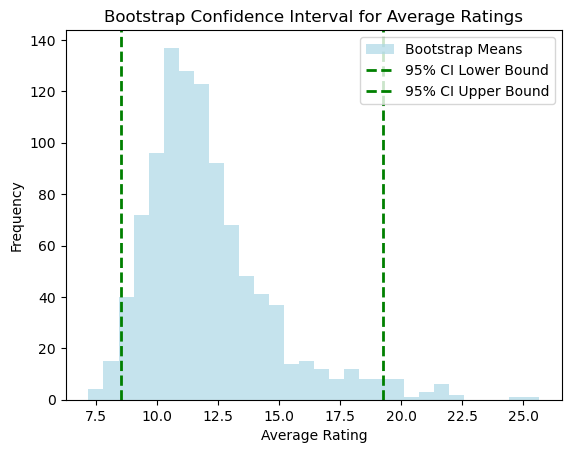

In [171]:
# extract rating values
rating_values = recipe_data['rating_val'].dropna().values

num_bootstrap_samples = 1000
sample_size = 100

# generate bootstrap samples
bootstrap_samples = [np.random.choice(rating_values, size=sample_size, replace=True) for _ in range(num_bootstrap_samples)]

# compute bootstrap means
bootstrap_means = [np.mean(sample) for sample in bootstrap_samples]

# compute the 95% confidence interval
confidence_interval_bootstrap = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"Bootstrap Confidence Interval (95%): {confidence_interval_bootstrap}")

# plot histogram of bootstrap means
plt.hist(bootstrap_means, bins=30, color='lightblue', alpha=0.7, label='Bootstrap Means')

plt.axvline(confidence_interval_bootstrap[0], color='green', linestyle='dashed', linewidth=2, label='95% CI Lower Bound')
plt.axvline(confidence_interval_bootstrap[1], color='green', linestyle='dashed', linewidth=2, label='95% CI Upper Bound')

plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Bootstrap Confidence Interval for Average Ratings')
plt.legend()
plt.show()




Summary statistics:
        rating_avg   rating_val
count  3293.000000  3293.000000
mean      4.497432    12.038567
std       0.611602    25.221305
min       1.000000     1.000000
25%       4.250000     3.000000
50%       4.666667     6.000000
75%       5.000000    13.000000
max       5.000000   776.000000


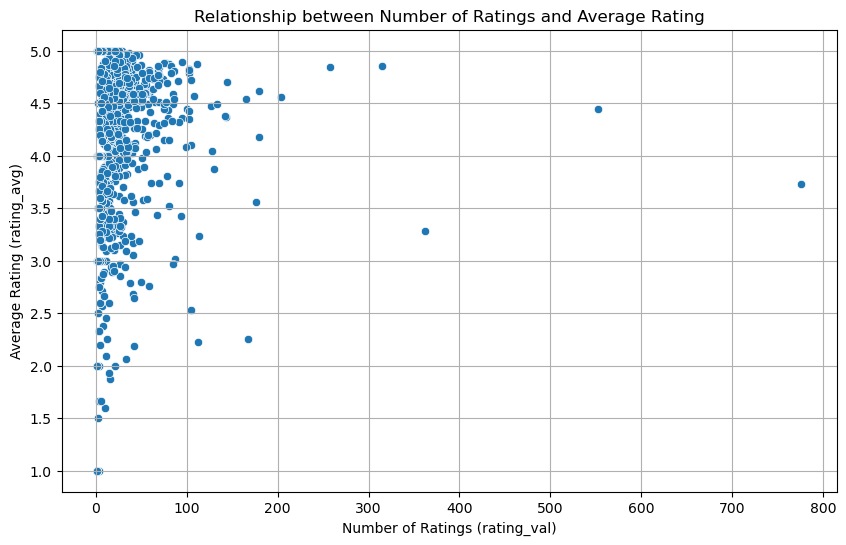

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('recipes.csv')

# convert value to numeric type and cleaned missing data
df['rating_avg'] = pd.to_numeric(df['rating_avg'])
df['rating_val'] = pd.to_numeric(df['rating_val'])

df = df.dropna(subset=['rating_avg', 'rating_val'])

print("Summary statistics:")
print(df[['rating_avg', 'rating_val']].describe())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='rating_val', y='rating_avg')
plt.title("Relationship between Number of Ratings and Average Rating")
plt.xlabel("Number of Ratings (rating_val)")
plt.ylabel("Average Rating (rating_avg)")
plt.grid(True)
plt.show()


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


features = ['title', 'rating_avg', 'rating_val', 'total_time', 'category', 'cuisine', 'ingredients']

# cleansed features data and created combined features in order to find cosine similarity 
for feature in features:
    df[feature] = df[feature].fillna('')
    df[feature] = df[feature].astype(str)


df['combine_features'] = df[features].apply(lambda row: ' '.join(row), axis=1)

cv = CountVectorizer()
count_matrix = cv.fit_transform(df['combine_features'])

cosine_sim = cosine_similarity(count_matrix)

# defined a helper function to get top recommendations of recipes
def get_recommendations(recipe_title, cosine_sim=cosine_sim, df=df, top_n=10):
    indices = pd.Series(df.index, index=df['title'].str.lower()).drop_duplicates()
    
    recipe_index = indices.get(recipe_title.lower())
    
    if recipe_index is None:
        print(f"Recipe titled '{recipe_title}' not found in the dataset.")
        return []
    
    sim_scores = list(enumerate(cosine_sim[recipe_index]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    recipe_indices = [i[0] for i in sim_scores]
    
    # return the titles of the top recommended recipes
    return df['title'].iloc[recipe_indices].tolist()

# test function
recipe_to_search = 'Chicken and coconut curry'
recommended_titles = get_recommendations(recipe_to_search)

print(f"Top 10 recommendations for '{recipe_to_search}':")
for i, title in enumerate(recommended_titles, start=1):
    print(f"{i}. {title}")


Top 10 recommendations for 'Chicken and coconut curry':
1. Vegan blackeye bean curry
2. Indian fish curry
3. Jamaican chicken curry
4. Leftover chicken curry
5. Chicken curry (shorshe murgi)
6. Chicken curry with basmati rice
7. Simple chicken curry
8. Coconut fish curry
9. Chicken and vegetable balti
10. Goan fish curry


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


df = pd.read_csv('recipes.csv')

# processed numerical features
num_features = ['rating_avg', 'rating_val', 'total_time']
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_features)
scaler = StandardScaler()
num_matrix = scaler.fit_transform(df[num_features])

# processed textual features
text_features = ['title', 'category', 'cuisine', 'ingredients']
for feature in text_features:
    df[feature] = df[feature].fillna('').astype(str)
df['text_combined'] = df[text_features].apply(lambda row: ' '.join(row), axis=1)
vectorizer = TfidfVectorizer()
text_matrix = vectorizer.fit_transform(df['text_combined'])

# combined numerical and textual features
num_matrix_sparse = 0.01 * num_matrix
from scipy.sparse import csr_matrix
num_matrix_sparse = csr_matrix(num_matrix_sparse)
final_matrix = hstack([text_matrix, num_matrix_sparse])

# defined function that returns 10 most similar recipes using matrix-vector product
def vec_space_method(recipe_title, top_n=10):
    indices = pd.Series(df.index, index=df['title'].str.lower()).drop_duplicates()
    recipe_index = indices.get(recipe_title.lower())
    if recipe_index is None:
        print(f"Recipe '{recipe_title}' not found.")
        return []
    recipe_vector = final_matrix[recipe_index]
    sim_scores = final_matrix.dot(recipe_vector.T).toarray().ravel()
    sim_scores[recipe_index] = -np.inf  
    top_indices = np.argsort(sim_scores)[::-1][:top_n]
    return df['title'].iloc[top_indices].tolist()

# test function
recipe_to_search = 'Chicken and coconut curry'
recommendations = vec_space_method(recipe_to_search)
print(f"Top 10 recommendations for '{recipe_to_search}':")
for i, title in enumerate(recommendations, 1):
    print(f"{i}. {title}\n")
    
    
# defined function for KNN similarity method 
def knn_similarity(recipe_title):
    return vec_space_method(recipe_title)


test_users = {
    'User 1': 'Chicken tikka masala',
    'User 2': 'Albanian baked lamb with rice',
    'User 3': 'Baked salmon with chorizo rice',
    'User 4': 'Almond lentil stew'
}

# defined function to evaluate the recommendation systems
def evaluate_recommendation_systems(test_users, vec_space_method, knn_similarity):
    coverage_vec = 0
    coverage_knn = 0
    personalization_vec = 0
    personalization_knn = 0

    for user, recipe in test_users.items():
        vec_recommendations = vec_space_method(recipe)
        knn_recommendations = knn_similarity(recipe)

        if vec_recommendations:
            coverage_vec += 1
            personalization_vec += len(set(vec_recommendations)) / len(vec_recommendations)

        if knn_recommendations:
            coverage_knn += 1
            personalization_knn += len(set(knn_recommendations)) / len(knn_recommendations)

    coverage_vec /= len(test_users)
    coverage_knn /= len(test_users)
    personalization_vec /= len(test_users)
    personalization_knn /= len(test_users)

    print(f"\nVector Space Method Coverage: {coverage_vec:.2f}")
    print(f"Vector Space Method Personalization: {personalization_vec:.2f}")
    print(f"KNN Similarity Coverage: {coverage_knn:.2f}")
    print(f"KNN Similarity Personalization: {personalization_knn:.2f}")

evaluate_recommendation_systems(test_users, vec_space_method, knn_similarity)

# classification model
df['tasty'] = (df['rating_val'].astype(float) >= 4.2).astype(int)
df_filtered = df.dropna(subset=['rating_val'])

X_train, X_test, y_train, y_test = train_test_split(final_matrix[df_filtered.index], df_filtered['tasty'], test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Classification Model Accuracy: {accuracy:.2f}")


Top 10 recommendations for 'Chicken and coconut curry':
1. Leftover chicken curry

2. Vegan blackeye bean curry

3. Chicken curry with basmati rice

4. Indian fish curry

5. Jamaican chicken curry

6. Dry curry of cabbage, carrot and coconut (Thoran) 

7. Coconut curry sauce

8. Simple chicken curry

9. Easy chicken curry

10. Quick fish curry

Recipe 'Albanian baked lamb with rice' not found.
Recipe 'Albanian baked lamb with rice' not found.

Vector Space Method Coverage: 0.75
Vector Space Method Personalization: 0.75
KNN Similarity Coverage: 0.75
KNN Similarity Personalization: 0.75
Classification Model Accuracy: 0.99
